In [1]:
#Import Files / Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Install new libraries
!pip install spectral

In [3]:
#Import Libraries

import spectral as sp
import spectral.io.envi as envi

import numpy as np
import scipy as sc

import pandas as pd

import sklearn
import skimage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from skimage.restoration import denoise_wavelet
from skimage import img_as_float
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns
# sns.set()

import joblib

#Set function to convert into rgb image
def to_rgb(x):
    dim = x.shape[-1]
    bands_section = int(dim/3)
    bands = [bands_section,(dim+bands_section)//2,dim-1]
    rgb = x[...,bands]
    for i in range(3):
        l,u = rgb[...,i].min(), rgb[...,i].max()
        rgb[...,i] = (rgb[...,i] - l) / (u - l)
    return np.clip(rgb,0,1)

## Read / Set the data

/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


(843, 221, 288)


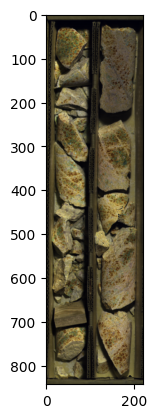

In [4]:
#Input data Image 1

#Path of hdr file image1
hdrFile1='/content/drive/MyDrive/SURF/HySpectral Project/data/VNIR AND SWIR interval/CMM-111_195_extracted_image.hdr'

#Path of img file image1
imgFile1='/content/drive/MyDrive/SURF/HySpectral Project/data/VNIR AND SWIR interval/CMM-111_195_extracted_image.img'

#Path of hdr file image1
hdrFile1='/content/drive/MyDrive/SURF/HySpectral Project/data/training_data/training_data_2023/B039 b_ref.hdr'

#Path of img file image1
imgFile1='/content/drive/MyDrive/SURF/HySpectral Project/data/training_data/training_data_2023/B039 b_ref.raw'


#Open image with envi
img = envi.open(hdrFile1, imgFile1)

#Load image
hypr_c195 = img.load()

hypr_c195.shape

#Image shape
hypr_shape = hypr_c195.shape

#Set index
index = hypr_shape[-1]

#Set RGB image for plotting
img_rgb = to_rgb(hypr_c195)

#Load image
plt.imshow(img_rgb)

print(hypr_c195[:,:,:288].shape)

#Set image for rest of calculations
hypr = hypr_c195

## Reshape: Original Image


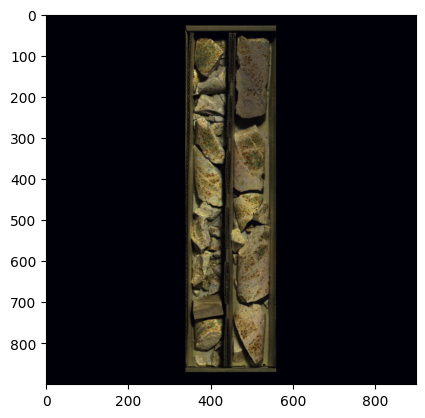

In [5]:
# Load your original hyperspectral image (replace with your own data loading code)
#hypr_c195 = load_hyperspectral_image()  # Replace with your data loading code

#Set index =
index = hypr_shape[-1]

# Define the target size
target_size = (900, 900, index)

# Create an empty array with the target size
padded_image = np.zeros(target_size, dtype=hypr_c195.dtype)

# Calculate the padding on each side
y_pad = (target_size[0] - hypr_c195.shape[0]) // 2
x_pad = (target_size[1] - hypr_c195.shape[1]) // 2

# Copy the original image to the center of the padded image
padded_image[y_pad:y_pad + hypr_c195.shape[0], x_pad:x_pad + hypr_c195.shape[1]] = hypr_c195

#Set RGB image for plotting
img_rgb = to_rgb(padded_image)

#Load image
plt.imshow(img_rgb)

In [6]:

#Principal Component Analysis, Dimensionality Reduction to 5 dimensions
pca = TruncatedSVD(n_components=5)

#Pipleline: Automates preprocessing steps
#Standarized data values into standard format,
pl  = Pipeline([('scale',StandardScaler()),('pca',pca)])

#Reshape and select just SWIR wavelenghts
padded_image  = padded_image.reshape(-1, index)

hyprT = pl.fit_transform(padded_image)

original_shape = padded_image.shape[:-1]+(5,)

print(original_shape)

#Apply the first mask pipeline (Data X Hyperspectral with first mask)
H_padded = padded_image.reshape(-1, index)

print(padded_image[:,:288].shape)
#H = H[:,swir_range]
H_padded = pl.transform(H_padded)

H_padded = H_padded.reshape(original_shape)

print(H_padded.shape)

(810000, 5)
(810000, 288)
(810000, 5)


#Finer masking (Apply and Select Kernel Mask 2)

In [7]:
#Open masks

#Path to .tiff mask file
tiffFileMask1 = '/content/drive/MyDrive/SURF/HySpectral Project/data/training_data/training_data_2023/B039 b_ref.png'

#Read image with plt
mask_c195 = plt.imread(tiffFileMask1)

#print('mask1:',mask_c195.shape)

#print(mask_c195)

#Select just the image first three channels: [:,:,:3]
mask_c195 = rgb2gray(mask_c195[:,:,:3]).astype(bool)


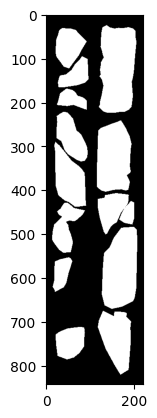

In [8]:
plt.imshow(mask_c195, cmap='binary_r')

#Results are boolean array

In [9]:
#Set labels
y  = mask_c195.reshape(-1)

#Set image:
#H = hypr_c195.reshape(-1, hypr_shape[-1])

## Reshape: Final Mask

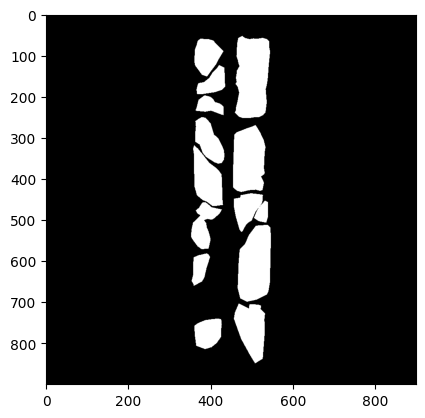

In [10]:
target_mask = (900, 900)

# Create an empty array with the target size
padded_mask = np.zeros(target_mask)

# Calculate the padding on each side
y_pad = (target_size[0] - mask_c195.shape[0]) // 2
x_pad = (target_size[1] - mask_c195.shape[1]) // 2

# Copy the original image to the center of the padded image
padded_mask[y_pad:y_pad + mask_c195.shape[0], x_pad:x_pad + mask_c195.shape[1]] = mask_c195

#Set RGB image for plotting
#img_rgb_mask = to_rgb(padded_mask)

#Load image
plt.imshow(padded_mask, cmap='binary_r')

In [11]:
# Combine data
XTrain = [H_padded, H_padded]
# Concatenate the two sets of features along the second axis (axis=1)
X_combined = np.concatenate(XTrain, axis=0)

# Concatenate the two sets of labels along the second axis (axis=1)
y_combined = np.concatenate((padded_mask, padded_mask), axis=None)

#Open more images and masks

In [12]:
import os

# Define the folder path
folder_path = "/content/drive/MyDrive/SURF/HySpectral Project/data/training_data/training_data_2023"

# Initialize lists to stored images
masks_images = []
hyper_images = []

#Sort all the files
all_filenames = sorted(os.listdir(folder_path))

# Loop through files in the folder
for filename in all_filenames:
    if filename.endswith(".tiff") or filename.endswith(".png"):
        # Load images with .tiff or .png extensions using plt.imread()
        mask = plt.imread(os.path.join(folder_path, filename))

        #Select just the image first three channels: [:,:,:3]
        mask = rgb2gray(mask[:,:,:3]).astype(bool)

        #Padthe mask
        target_mask = (900, 900)

        # Create an empty array with the target size
        padded_mask = np.zeros(target_mask)

        # Calculate the padding on each side
        y_pad = (target_size[0] - mask.shape[0]) // 2
        x_pad = (target_size[1] - mask.shape[1]) // 2

        # Copy the original image to the center of the padded image
        padded_mask[y_pad:y_pad + mask.shape[0], x_pad:x_pad + mask.shape[1]] = mask

        #Append to the array after making it a tensor
        #padded_mask = tf.convert_to_tensor(padded_mask, dtype=tf.float32)  # Use dtype=tf.bool for boolean labelc

        #padded_mask = padded_mask.reshape((1,) + padded_mask.shape + (1,))

        masks_images.append(padded_mask)


    elif filename.endswith(".hdr"):
        # For .hdr files, check if corresponding .raw or .img file exists
        basename = os.path.splitext(filename)[0]
        raw_file = os.path.join(folder_path, basename + ".raw")
        img_file = os.path.join(folder_path, basename + ".img")

        if os.path.exists(raw_file):
          # Load hyperspectral images with .hdr and .raw files using envi.open()
          hypr = envi.open(os.path.join(folder_path, filename), raw_file)

          #Load image
          hypr = hypr.load()

        elif os.path.exists(img_file):
          # Load hyperspectral images with .hdr and .img files using envi.open()
          hypr = envi.open(os.path.join(folder_path, filename), img_file)

          #Load image
          hypr = hypr.load()


        #Reshape to choose first 288 bands
        hypr = hypr[:,:,:288]

        #Padd the image
        index = hypr.shape[-1]

        # Define the target size
        target_size = (900, 900, index)

        # Create an empty array with the target size
        padded_hypr = np.zeros(target_size, dtype=hypr.dtype)

        # Calculate the padding on each side
        y_pad = (target_size[0] - hypr.shape[0]) // 2
        x_pad = (target_size[1] - hypr.shape[1]) // 2

        # Copy the original image to the center of the padded image
        padded_hypr[y_pad:y_pad + hypr.shape[0], x_pad:x_pad + hypr.shape[1]] = hypr

        #Apply pca:

        #Apply the first mask pipeline (Data X Hyperspectral with first mask)
        original_shape = padded_hypr.shape[:-1]+(5,)
        padded_hypr = padded_hypr.reshape(-1, index)

        #select the first 288 band

        #Reshape and select just SWIR wavelenghts

        padded_hypr = pl.fit_transform(padded_hypr)
        padded_hypr = padded_hypr.reshape(original_shape)

        #Append to the array after creating tensor
        #padded_hypr = tf.convert_to_tensor(padded_hypr, dtype=tf.float32)
        #padded_hypr = padded_hypr.reshape((1,) + padded_hypr.shape)  # Adding a batch dimension
        #padded_hypr = padded_hypr.reshape((1,) + padded_hypr.shape)

        hyper_images.append(padded_hypr)

        print("Processed image: ", basename + ".img")

# Combine data
X_data = np.array(hyper_images)

# Concatenate the two sets of labels along the second axis (axis=1)
y_data = np.array(masks_images)


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B020 b_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B020_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B021 b_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B021_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B022 b_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B022_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B023 b_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B023_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B024 b_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B024_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B025 b_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B025_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B026 b_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B026_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B039 b_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B039_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B062 b_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B062_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B070 b_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B070_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B071 b_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B071_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B072 b_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B072_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B073 b_ref.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B073_ref.img
Processed image:  CMM-111_195.img
Processed image:  CMM-111_196.img
Processed image:  CMM-111_197.img


In [13]:
masks_images[0].shape

(900, 900)

## CNN Model

Train Model with Image 1 and the final mask above.


In [14]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

np.random.seed(0)
tf.random.set_seed(0)

In [15]:
# Define constants
num_kernels = 16
dense_layer_neurons = 64
kernels_size = (3, 3)
pooling_size = (2, 2)
image_shape = original_shape  # Assuming images have shape (900, 900, 5)


In [16]:
#Create test and train datasets

# Define the ratio for splitting the data (e.g., 80% train, 20% test)
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate the number of samples for training and testing
num_samples = len(X_data)
num_train_samples = int(train_ratio * num_samples)
num_test_samples = num_samples - num_train_samples

# Shuffle the indices of the samples
indices = np.random.permutation(num_samples)

# Split the indices into training and testing indices
train_indices = indices[:num_train_samples].astype(int)
test_indices = indices[num_train_samples:].astype(int)

# Split the data into training and testing sets
X_train, X_test = X_data[train_indices], X_data[test_indices]
y_train, y_test = y_data[train_indices], y_data[test_indices]

#Set batch size
batch_size = 32

# Create a dataset from multiple images and their corresponding labels
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=2).batch(batch_size)
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Shuffle and batch the dataset (adjust batch size as needed)
#batch_size = 32
#dataset_train = dataset_train.shuffle(buffer_size=2).batch(batch_size)

# Verify the shapes of the first batch in the dataset
for batch in dataset_train.take(1):
    hypr_batch, mask_batch = batch
    print("Input shape:", hypr_batch.shape)
    print("Target shape:", mask_batch.shape)

Input shape: (23, 900, 900, 5)
Target shape: (23, 900, 900)


In [17]:
print(y_train.shape)
print(train_indices.dtype)
print(len(X_data[0,1]))


(23, 900, 900)
int64
900


In [18]:
dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 900, 900, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 900, 900), dtype=tf.float64, name=None))>

In [19]:
# Assuming you have defined your model and compiled it
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(900, 900, 5)),

    # Encoder
    tf.keras.layers.Conv2D(num_kernels, kernels_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=pooling_size, padding='same'),
    tf.keras.layers.Conv2D(num_kernels * 2, kernels_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=pooling_size, padding='same'),

    # Decoder
    tf.keras.layers.Conv2DTranspose(num_kernels * 2, kernels_size, activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D(size=pooling_size),
    tf.keras.layers.Conv2DTranspose(num_kernels, kernels_size, activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D(size=pooling_size),

    # Output layer
    tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same'),  # Sigmoid activation for binary classification
])

# Print the summary of the model
model.summary()

# Compile the model
model.compile(
    loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

# Set the number of epochs (you can adjust this based on your needs)
epochs = 50

# Train the model
history = model.fit(dataset_train, validation_data=dataset_test, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 900, 900, 16)      736       
                                                                 
 max_pooling2d (MaxPooling2  (None, 450, 450, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 450, 450, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 225, 225, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 225, 225, 32)      9248      
 anspose)                                                        
                                                        

# Results / Predictions

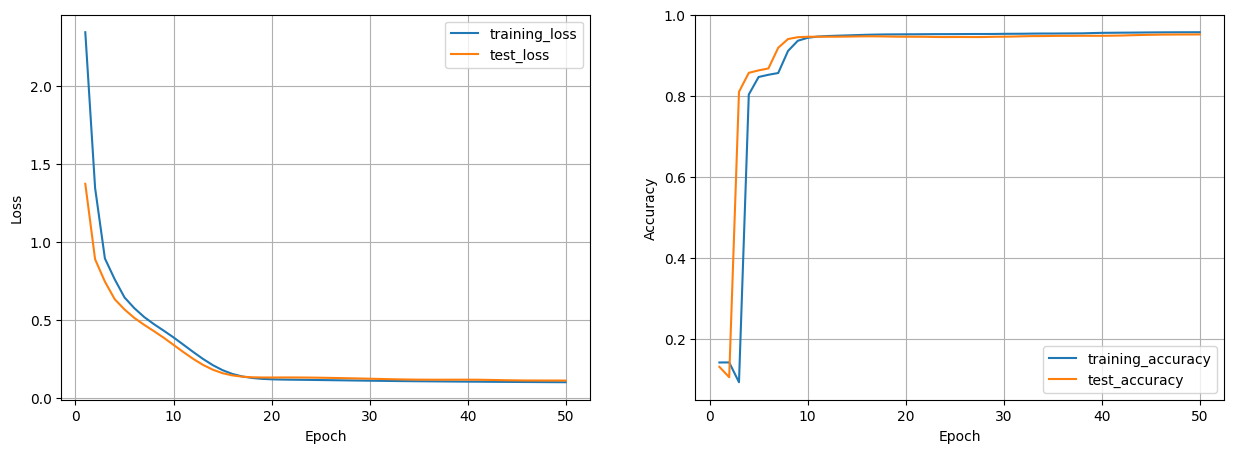

In [20]:
# Ploting results function:

def plot_results(history):
    epoch_num = np.arange(1, len(history.history['loss'])+1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_num, history.history['loss'], label='training_loss')
    plt.plot(epoch_num, history.history['val_loss'], label='test_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epoch_num, history.history['accuracy'], label='training_accuracy')
    plt.plot(epoch_num, history.history['val_accuracy'], label='test_accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

# Plot results and print summary
plot_results(history)


# Open and run testing data folder

In [21]:
# Define the folder path
folder_path_test = "/content/drive/MyDrive/SURF/HySpectral Project/data/training_data/testing_data_2023"

# Initialize lists to stored images
hyper_test = []
hyper_test_shape = [] #Save the original shape to later cropped the result from CNN
hyper_test_basenames = []

#Sort all the files
all_filenames_test = sorted(os.listdir(folder_path_test))

# Loop through files in the folder
for filename in all_filenames_test:

    if filename.endswith(".hdr"):
        # For .hdr files, check if corresponding .raw or .img file exists
        basename = os.path.splitext(filename)[0]
        raw_file = os.path.join(folder_path_test, basename + ".raw")
        img_file = os.path.join(folder_path_test, basename + ".img")

        if os.path.exists(raw_file):
          # Load hyperspectral images with .hdr and .raw files using envi.open()
          hypr = envi.open(os.path.join(folder_path_test, filename), raw_file)

          #Load image
          hypr = hypr.load()

        elif os.path.exists(img_file):
          # Load hyperspectral images with .hdr and .img files using envi.open()
          hypr = envi.open(os.path.join(folder_path_test, filename), img_file)

          #Load image
          hypr = hypr.load()

        #Save the basename
        hyper_test_basenames.append(basename)

        #Reshape to choose first 288 bands
        hypr = hypr[:,:,:288]

        #Padd the image
        index = hypr.shape[-1]

        #save the image original shape
        hyper_test_shape.append(hypr.shape[:-1])

        # Define the target size
        target_size = (900, 900, index)

        # Create an empty array with the target size
        padded_hypr = np.zeros(target_size, dtype=hypr.dtype)

        # Calculate the padding on each side
        y_pad = (target_size[0] - hypr.shape[0]) // 2
        x_pad = (target_size[1] - hypr.shape[1]) // 2

        # Copy the original image to the center of the padded image
        padded_hypr[y_pad:y_pad + hypr.shape[0], x_pad:x_pad + hypr.shape[1]] = hypr

        #Apply pca:

        #Apply the first mask pipeline
        original_shape = padded_hypr.shape[:-1]+(5,)
        padded_hypr = padded_hypr.reshape(-1, index)
        padded_hypr = pl.fit_transform(padded_hypr)
        padded_hypr = padded_hypr.reshape(original_shape)

        hyper_test.append(padded_hypr)

        print("Processed image: ", filename + ".img")

/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B075 b_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B075_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B079 b_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B079_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B080 b_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B080_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B081 b_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B169_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B170_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B171_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B172_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B173_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B174_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B175_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B190_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B191_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B192_ref.hdr.img


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Processed image:  B200 b_ref.hdr.img
Processed image:  CMM-111_198.hdr.img


In [ ]:

# Create a dataset from multiple images and their corresponding labels
#dataset_test = tf.data.Dataset.from_tensor_slices((np.array(hyper_test)))


# Convert to TensorFlow tensors
#padded_hypr = padded_hypr.reshape((1,) + padded_hypr.shape)
#padded_hypr = tf.convert_to_tensor(padded_hypr, dtype=tf.float32)
hyper_test = np.array(hyper_test)

y_hat = model.predict(hyper_test)



<ipython-input-27-6609935dff4c>:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,j)


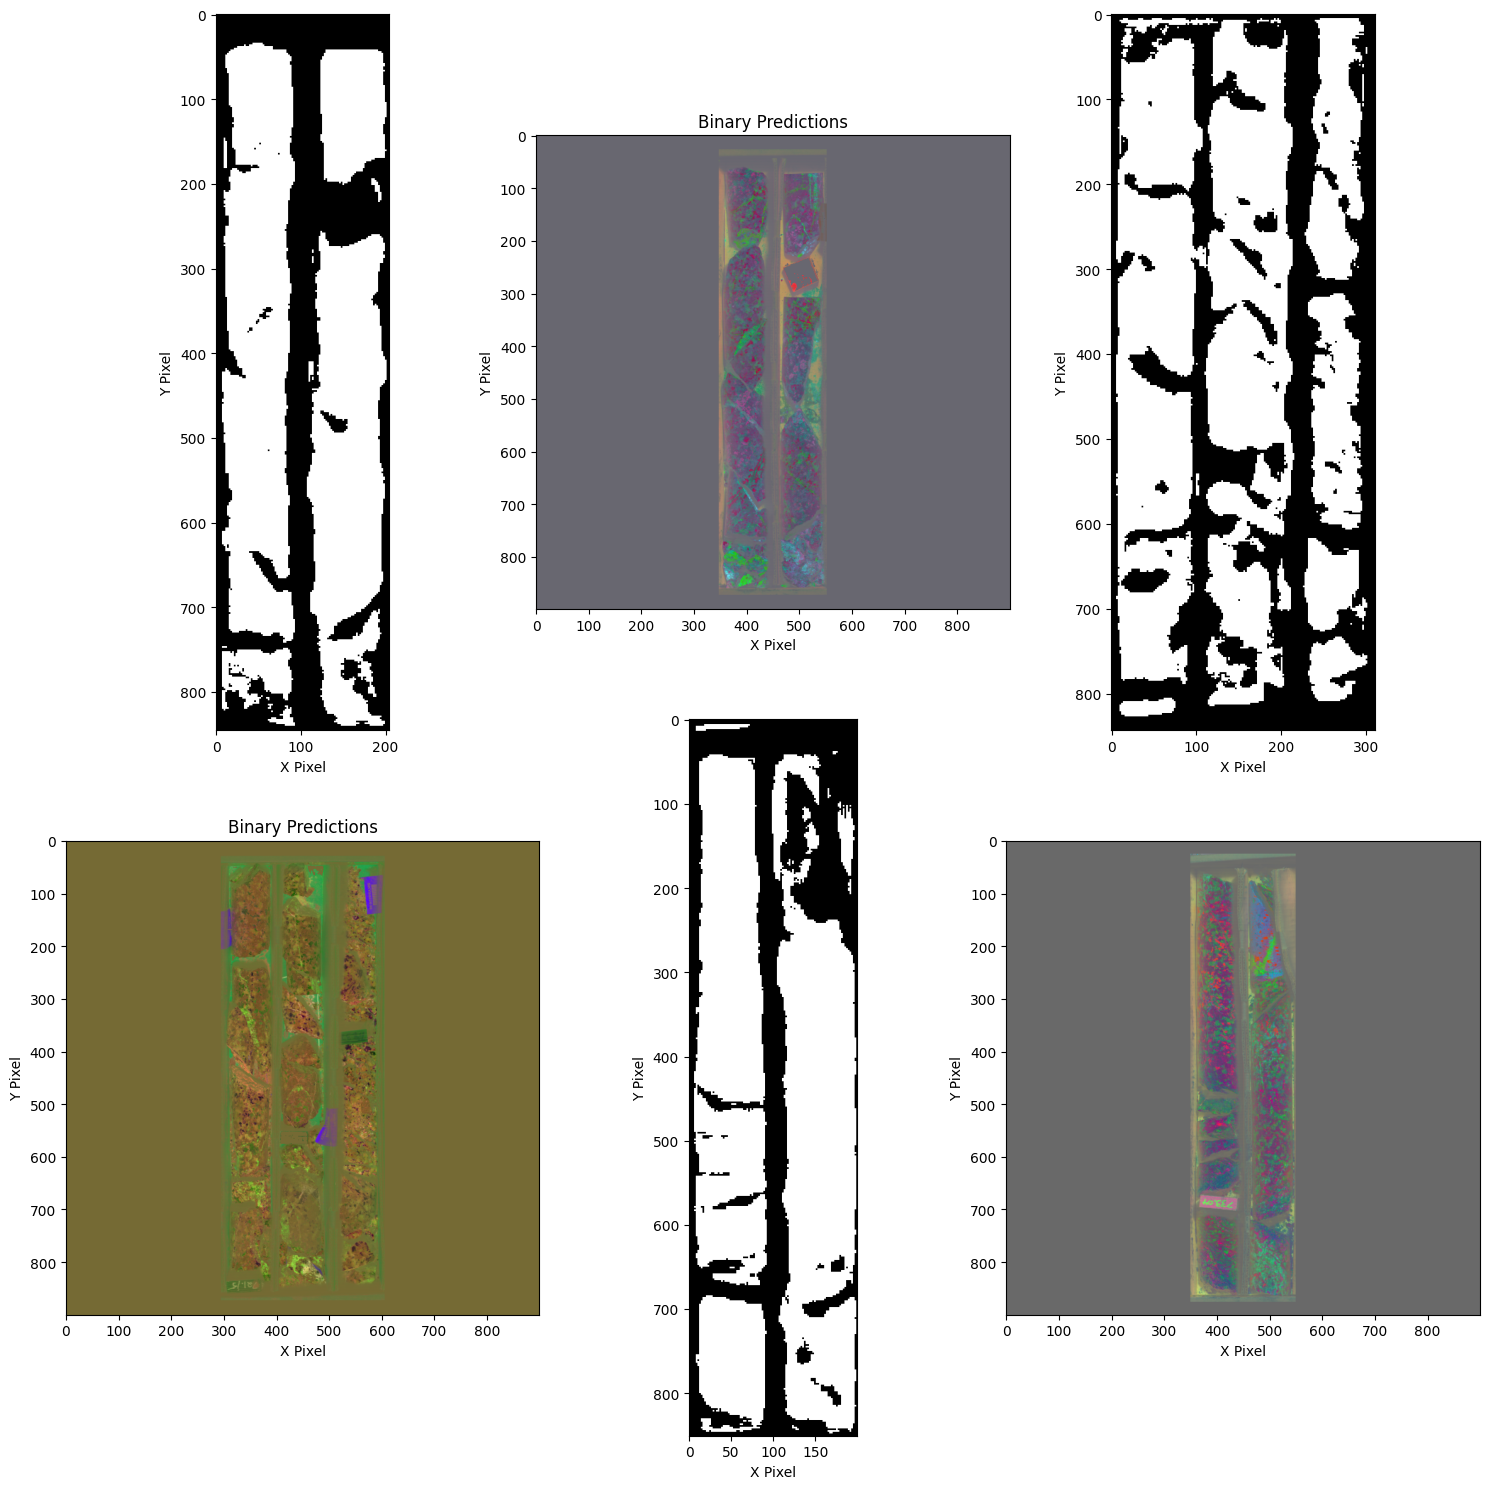

In [27]:
import imageio
from PIL import Image

# Define the folder path
folder_path_test = "/content/drive/MyDrive/SURF/HySpectral Project/data/CNN_results/"

plt.figure(figsize=(15,15))

j=1

for i in range(3):
  threshold = 0.4
  y_n = (y_hat[i] > threshold).astype(int)

  # Assuming binary_predictions is your model's binary output
  y_n = y_n.reshape((900, 900))

  #Reshape to original size

  original_size = hyper_test_shape[i]

  # Calculate the cropping coordinates
  y_start = (y_n.shape[0] - original_size[0]) // 2
  x_start = (y_n.shape[1] - original_size[1]) // 2
  y_end = y_start + original_size[0]
  x_end = x_start + original_size[1]

  # Crop the padded image to the original size
  y_n = y_n[y_start:y_end, x_start:x_end]

  #Save the image
  plt.imsave(folder_path_test+hyper_test_basenames[i]+".png",y_n, cmap='gray')

  # Plot the reshaped binary predictions
  #plt.imshow(y_n, cmap='gray')
  plt.title('Binary Predictions')

  plt.subplot(2,3,j)
  mask = np.expand_dims(y_n, axis=-1)
 # hyper_test[mask==0] = np.nan
  plt.imshow(mask, cmap='gray')
  plt.xlabel('X Pixel')
  plt.ylabel('Y Pixel')

  j=j+1

  plt.subplot(2,3,j)
  plt.imshow(to_rgb(hyper_test[i]))
  plt.xlabel('X Pixel')
  plt.ylabel('Y Pixel')

  j=j+1


plt.tight_layout()
plt.show()


In [ ]:
  threshold = 0.4
  y_hat = (y_hat[i] > threshold).astype(int)

  # Assuming binary_predictions is your model's binary output
  y_hat = y_hat.reshape((900, 900))

  # Plot the reshaped binary predictions
  plt.imshow(y_hat, cmap='gray')
  plt.title('Binary Predictions')
  plt.show()


In [ ]:
# Assuming hypr is your single image
# Assuming mask is your label data
hypr2 = H_padded2.reshape((1,) + H_padded2.shape)  # Adding a batch dimension

# Convert to TensorFlow tensors
hypr2 = tf.convert_to_tensor(hypr2, dtype=tf.float32)

predictions = model.predict(hypr2)

threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

#Print shape
print(binary_predictions.shape)

# Assuming binary_predictions is your model's binary output
binary_predictions_reshaped = binary_predictions.reshape((900, 900))

# Plot the reshaped binary predictions
plt.imshow(binary_predictions_reshaped, cmap='gray')
plt.title('Binary Predictions')
plt.show()

In [ ]:
# Assuming hypr is your single image
# Assuming mask is your label data
hypr = H_padded.reshape((1,) + H_padded2.shape)  # Adding a batch dimension

# Convert to TensorFlow tensors
hypr = tf.convert_to_tensor(hypr, dtype=tf.float32)

predictions = model.predict(hypr)

threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

#Print shape
print(binary_predictions.shape)

# Assuming binary_predictions is your model's binary output
binary_predictions_reshaped = binary_predictions.reshape((900, 900))

# Plot the reshaped binary predictions
plt.imshow(binary_predictions_reshaped, cmap='gray')
plt.title('Binary Predictions')
plt.show()